## Phase 2 Final Project Submission

- Student Name: Tai Ngoc Bui
- Student Pace: Flex
- Scheduled Project Review:
- Instructor Name: Morgan Jones

### 1. Business Understanding

This data exploratory project focuses on analyzing characteristics of successful movies at the box office to support the company's strategic investment in the movie industry. The goal is to gain valuable insights contributing to movie production success and provide meaningful recommendations to major stakeholders of the investments.

### 2. Data Understanding

The dataset used in this analysis extracted from various different movie sources including IMDb, the Numbers, and TMDB. As these datasets were collected from different sources, they have different formats. While TMDB and the Numbers datasets are compressed as CVS files, the IMDb, the largest dataset among the three, is stored within a SQLite database. <br>
These datasets not only contain movies' information on their cast, production crew, budget, and revenues, etc. but also the public opinions regarding the movies' success such as ratings and votes.

### 3. Data Preparation

In [1]:
#import appropriate libraries for analysis and visualization
import pandas as pd
import sqlite3
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

%matplotlib inline

#### a. Load Data to Dataframes

In [42]:
conn = sqlite3.connect('data\im.db')
df = pd.read_sql('''SELECT title, start_year, runtime_minutes, averagerating, numvotes, 
                    primary_name, category FROM
                    (SELECT  * FROM movie_basics LEFT JOIN 
                             (SELECT * FROM movie_akas LEFT JOIN movie_ratings USING(movie_id))
                             USING(movie_id)) LEFT JOIN
                             (SELECT movie_id, primary_name, category FROM principals LEFT JOIN
                             persons USING(person_id) WHERE death_year IS NULL) USING(movie_id)                             
                             ''', conn)


In [3]:
#Load all csv and tsc files into dataframe
df1 = pd.read_csv('Data/tmdb.movies.csv', parse_dates = ['release_date'], converters={'genre_ids': pd.eval})
df2 = pd.read_csv('Data/tn.movie_budgets.csv', parse_dates = ['release_date'])
df3 = pd.read_csv('Data/rt.movie_info.tsv', sep = '\t', parse_dates = ['theater_date','dvd_date'])
df4 = pd.read_csv('Data/rt.reviews.tsv', sep = '\t', encoding='unicode_escape', parse_dates = ['date'])


#### b. Cleaning Dataframes

##### IMDb Dataset

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928123 entries, 0 to 2928122
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   title            object 
 1   start_year       int64  
 2   runtime_minutes  float64
 3   averagerating    float64
 4   numvotes         float64
 5   primary_name     object 
 6   category         object 
dtypes: float64(3), int64(1), object(3)
memory usage: 156.4+ MB


In [46]:
df.drop_duplicates(inplace = True)
df.isna().sum()

title              128692
start_year              0
runtime_minutes    243179
averagerating      494112
numvotes           494112
primary_name         1697
category             1313
dtype: int64

In [47]:
# As I will use this dataset to analyze directors' success, it is best to drop rows that 
# have Nan director values
df.dropna(subset=['title','primary_name'], inplace = True)
# fill column runtime_minutes' Nan values with its mode, 
#  meanwhile, averagerating and numvotes' Nan values will be filled with 0
runtime = df['runtime_minutes'].mode().values[0]
df.fillna(value = {'runtime_minutes':runtime, 'averagerating':0, 'numvotes':0}, inplace = True)

In [48]:
df.isna().sum()

title              0
start_year         0
runtime_minutes    0
averagerating      0
numvotes           0
primary_name       0
category           0
dtype: int64

##### TMDB Dataset

In [8]:
#Let's have a overview of the TMDB dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         26517 non-null  int64         
 1   genre_ids          26517 non-null  object        
 2   id                 26517 non-null  int64         
 3   original_language  26517 non-null  object        
 4   original_title     26517 non-null  object        
 5   popularity         26517 non-null  float64       
 6   release_date       26517 non-null  datetime64[ns]
 7   title              26517 non-null  object        
 8   vote_average       26517 non-null  float64       
 9   vote_count         26517 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 2.0+ MB


In [9]:
#Check the number of Nan values in TMDB dataset
df1.isna().sum()

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

I realize the genres in TMDB dataset are all recorded as id code. I found the actual name for each of genre id from TMDB website and store them in dictionary d. I will split the data stored in column genre_ids into individual columns. If a movie is assigned as that particular genre, the cell in that genre column will show 1, else it will show 0.

In [10]:
# Split the genre_ids column into multiple columns and change the genre_ids to identical genres
d = {28: 'Action',
12: 'Adventure',
16: 'Animation',
35: 'Comedy',
80: 'Crime',
99: 'Documentary',
18: 'Drama',
10751: 'Family',
14: 'Fantasy',
36: 'History',
27: 'Horror',
10402: 'Music',
9648: 'Mystery',
10749: 'Romance',
878: 'Science Fiction',
10770: 'TV Movie',
53: 'Thriller',
10752: 'War',
37: 'Western'}
# Split the genre_ids column which is a string type into multiple columns
# if movie contains a certain genre, the movie's genre column will show 1, else 0
genres = np.unique(np.concatenate(np.array(df1['genre_ids'])))
genres = [int(x) for x in genres]
df1[genres] = 0
for i, row in df1.iterrows():
    for g in row['genre_ids']:
        df1.at[i,g] = 1
        
#Change the genre_ids into genres' identical names        
df1.rename(columns = d, inplace = True)
# the genres array now contains the genres identical names, not ids
genres = list(d.values())

# create a new column containing the number of genres associated with the movie
df1['genre_len'] = [len(x) for x in df1['genre_ids']]

##### The Numbers Dataset

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 271.2+ KB


In [12]:
#Check the number of Nan values in The Numbers dataset
df2.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

I realize all data stored in columns production_budget, domestic_gross and worldwide_gross are under string type. To convert these columns to float type, I need to strip the special character $ out of the string before converting. I also create a new column ROI which stands for return on investment. ROI is calculated as the difference between worldwide_gross and production_budget divided by production_budget.

In [13]:
#convert string types columns into float types
df2['production_budget'] = df2['production_budget'].replace('[\$,]', '', regex=True).astype(float)
df2['domestic_gross'] = df2['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
df2['worldwide_gross'] = df2['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)

#Create ROI (Return on Investment) column: ROI = (earnings - budget)/budget
df2['ROI'] = (df2['worldwide_gross']-df2['production_budget'])/df2['production_budget']


##### Joining TMDB and The Numbers dataset

While TMDB dataset has over 25000 data points of different movies with great features such as genres, popularity, vote average; it is missing gross revenue - one of the crucial features detemining the success of a movie. Such gross revenue information is only carried by the Numbers' dataset. As a result, I joined the two dataset together using their title columns to better understannd how different movies' features contributing to their success.

In [14]:
#join dataset from TMDB and The Numbers using their titles. As The Numbers dataset
# have a greater number of data points, I use right join to maximize the data points after the join
df12 =  pd.merge(df1, df2, left_on='original_title', right_on='movie', how='right')
df12.dropna(inplace = True)
# Keep only important columns
keep = ['title','vote_average','vote_count', 'release_date_x','popularity','production_budget','domestic_gross','worldwide_gross', 'ROI','genre_len'] + genres
df12 = df12[keep]

#reset index so that the index shows continuous values rather than the join index
df12.reset_index(inplace=True)
df12.drop(['index'], axis = 1, inplace = True)
df12.drop_duplicates(inplace = True)

#create new column "released_month" which is the month part of "released_date"
df12['release_month'] = pd.DatetimeIndex(df12['release_date_x']).month

##### Joining IMDb and The Numbers dataset

I plan to analyze what are the best directors in terms of both ROI and overall ratings later. While IMDb's dataset contains detail information regarding movies and directors, it does not have any gross revenue or production budget information. Such data can only be found under The Numbers' dataset. Thus, I decide to merge IMDb's and The Numbers' dataset together.

In [50]:
# Here I am only interested in movies that have directors' information
df_dir = df[df['category'] == 'director']

# Merging data with a right join
df_dir =  pd.merge(df_dir, df2, left_on=['title','start_year'], right_on=['movie','year'], how='right')
df_dir = df_dir[['title','averagerating','numvotes','primary_name','category',
                 'production_budget','domestic_gross','worldwide_gross','ROI']]
# Create a new column ROI in the joined dataframe
df_dir['ROI'] = (df_dir['worldwide_gross'] - df_dir['production_budget']) /df_dir['production_budget']

df_dir.dropna(inplace = True)




## Exploratory Data Analysis

### Overview Trends 

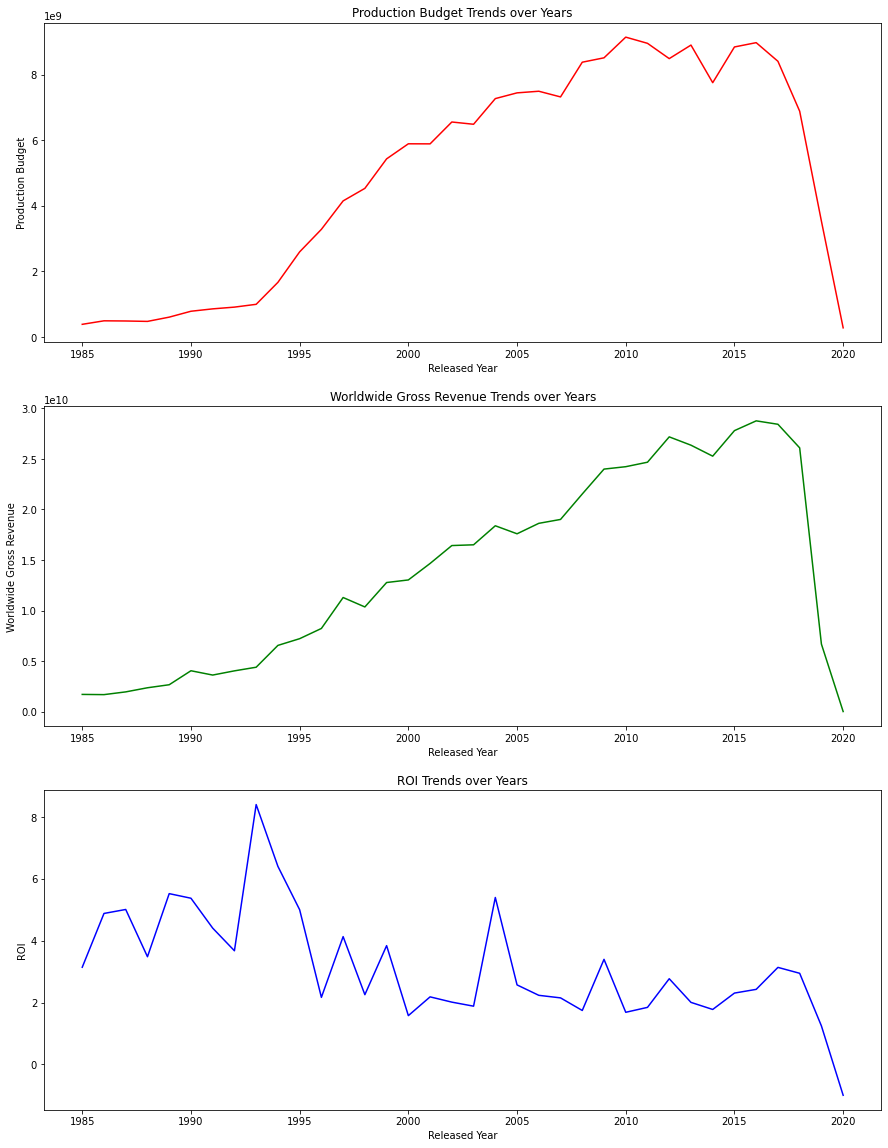

In [16]:
df2['year'] = pd.DatetimeIndex(df2['release_date']).year
df_trends = df2[df2['year'] >= 1985]
d_year = df_trends.groupby('year').aggregate({'production_budget':'sum',
                                       'worldwide_gross':'sum','ROI':'mean'})
fig, ((ax1), (ax2), (ax3)) = plt.subplots(figsize = (15,20), nrows = 3)
ax1.plot(d_year.index, d_year.production_budget, color = 'red')
ax1.set_xlabel('Released Year')
ax1.set_ylabel('Production Budget')
ax1.set_title('Production Budget Trends over Years')

ax2.plot(d_year.index, d_year.worldwide_gross, color = 'green')
ax2.set_xlabel('Released Year')
ax2.set_ylabel('Worldwide Gross Revenue')
ax2.set_title('Worldwide Gross Revenue Trends over Years')

ax3.plot(d_year.index, d_year.ROI, color = 'blue')
ax3.set_xlabel('Released Year')
ax3.set_ylabel('ROI')
ax3.set_title('ROI Trends over Years')
plt.show();

The above charts show that the investment in the movie industry has consistently increased from 1985 - 2018. This consistent investment trend in movie industry also leads to growing worldwide gross revenue for movie production. However, the Covid-19 incident in late 2019 - early 2020 had caused a deep dive in both movie budget production and worldwide gross revenue.
An incentive for investors to pour their investment in the movie industry is due to its high ROI. Though ROI is somewhat on a down trend from 1985 - 2020, the yearly average return had been consistently stayed above 200% from 1985 - 2018. 

### First Recommendation

#### a. In which month big movies (production budget over 100M) released?

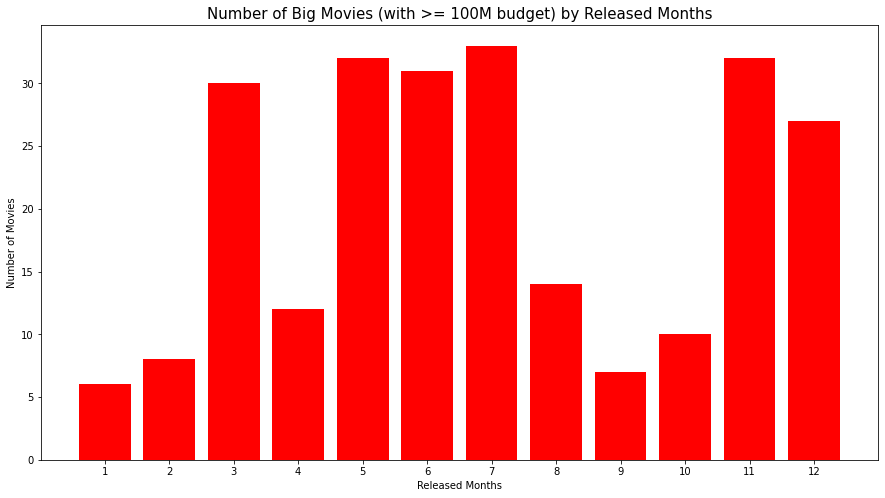

In [17]:
# group the joined dataset by release month and filter only those moview with production cost
# more than 100M
big_movies = df12[df12['production_budget'] >= 100000000].groupby('release_month').count()

#Graphing the data
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(x = big_movies.index, height = big_movies['production_budget'], color = 'red')
plt.xticks(range(1,13))
plt.xlabel('Released Months')
plt.ylabel('Number of Movies')
plt.title('Number of Big Movies (with >= 100M budget) by Released Months', fontsize = 15)
plt.show();

#### b. In which month do movies hit best gross revenue?

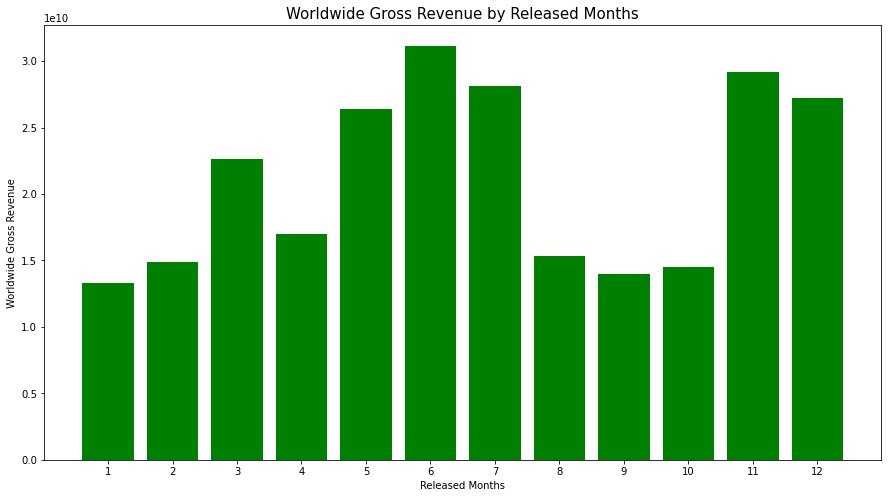

In [18]:
# Group the joined dataset by released_month but this time, we want to view worldwide gross revenue
# distributed by released month
release_month = df12.groupby('release_month').sum()

# Graphing the data
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(x = release_month.index, height = release_month['worldwide_gross'], color = 'green')
plt.xticks(range(1,13))
plt.xlabel('Released Months')
plt.ylabel('Worldwide Gross Revenue')
plt.title('Worldwide Gross Revenue by Released Months', fontsize = 15)
plt.show();

#### c. In which month do movies achieve best ROI?

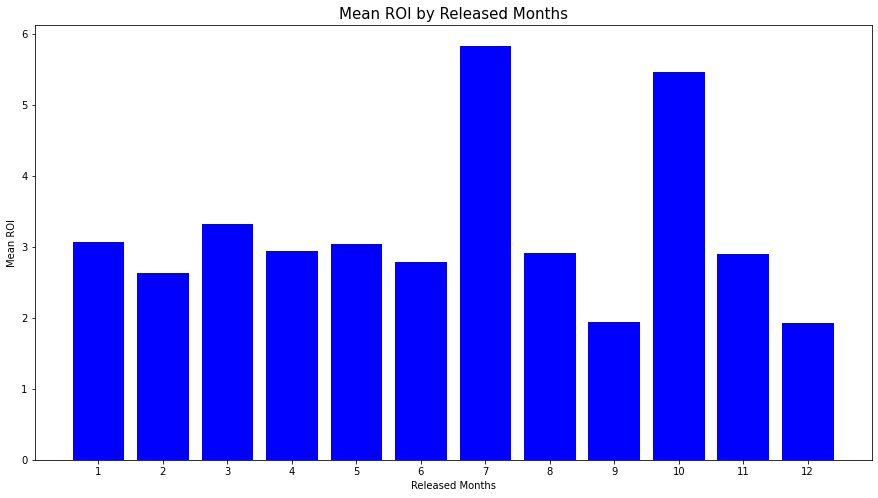

In [19]:
# Group the joined dataset by released_month, but this time, we want to compare them by mean values 
# of the movies' ROI rate
roi_month = df12.groupby('release_month').mean()

# Graphing the data
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(x = roi_month.index, height = roi_month['ROI'], color = 'blue')
plt.xticks(range(1,13))
plt.xlabel('Released Months')
plt.ylabel('Mean ROI')
plt.title('Mean ROI by Released Months', fontsize = 15)
plt.show();

With our 12 months analysis, we can realize July and October are the 2 best months in which movies can achieve great ROI for studio producers. On the other hand, we also want to avoid compete directly with the major movies in the box office (assumed with over 100M budget production). The first and second chart show that most big movies are often released during summer (Jun - August) and the last two months of the year (November and December). As a result, my first recommendation to the stakeholders is to prioritize releasing movie in October of the year. Not only we can avoid compete directly with major movies, but also have a higher chance of hitting higher ROI rates.

### Second Recommendation

In [20]:
#setting format not to display scientific notation
pd.set_option('display.float_format', lambda x: '%.0f' % x)

#create a new column rev_per_genre 
df12['rev_per_genre'] = df12['worldwide_gross'] / df12['genre_len']

# create a new column budget_per_genre
df12['budget_per_genre'] = df12['production_budget'] / df12['genre_len']

# distribute budget per genre and revenue per genre into each of genre column according to movies' genre
gross_rev_genre = df12[genres].multiply(df12['rev_per_genre'], axis = 0)
budget_genre = df12[genres].multiply(df12['budget_per_genre'], axis = 0)

#get the total revenue and budget production associated with each genres
sum_rev_genres = gross_rev_genre.sum(axis = 0)
sum_budget_genres = budget_genre.sum(axis = 0)
# obtain return on investment associated with each genres
roi_genres = round(sum_rev_genres/sum_budget_genres - 1,2) 

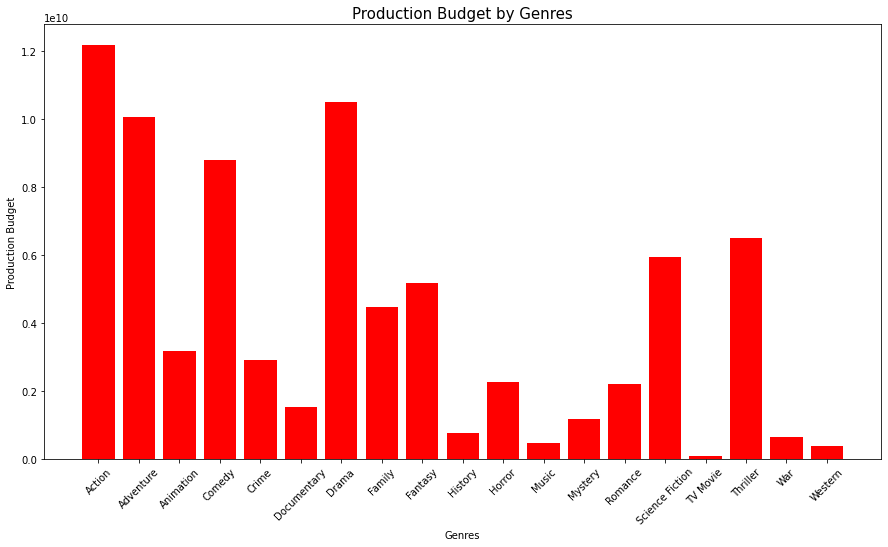

In [21]:
# Chart production budget by genres
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(x = sum_budget_genres.index, height = sum_budget_genres.values, color = 'red')
plt.xticks(rotation = 45)
plt.xlabel('Genres')
plt.ylabel('Production Budget')
plt.title('Production Budget by Genres', fontsize = 15)
plt.show();

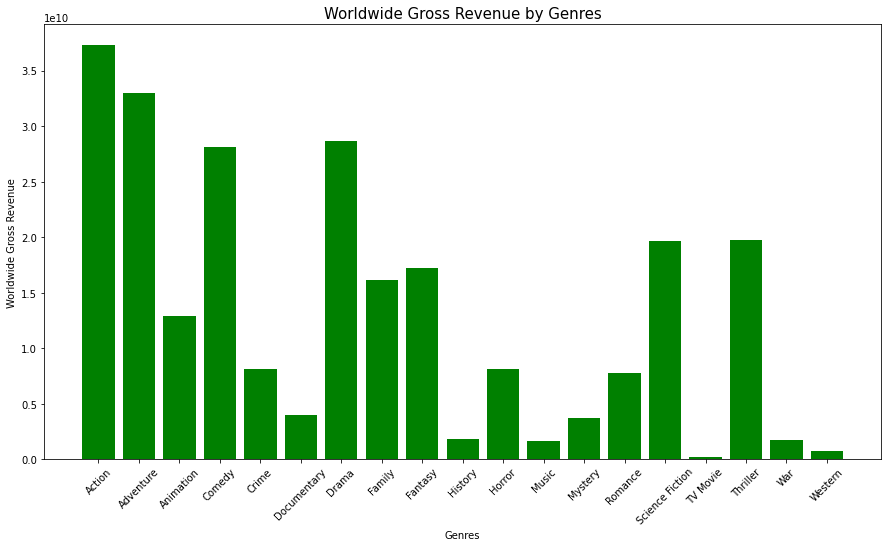

In [22]:
# Chart worldwide gross revenue by genres
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(x = sum_rev_genres.index, height = sum_rev_genres.values, color = 'green')
plt.xticks(rotation = 45)
plt.xlabel('Genres')
plt.ylabel('Worldwide Gross Revenue')
plt.title('Worldwide Gross Revenue by Genres', fontsize = 15)
plt.show();

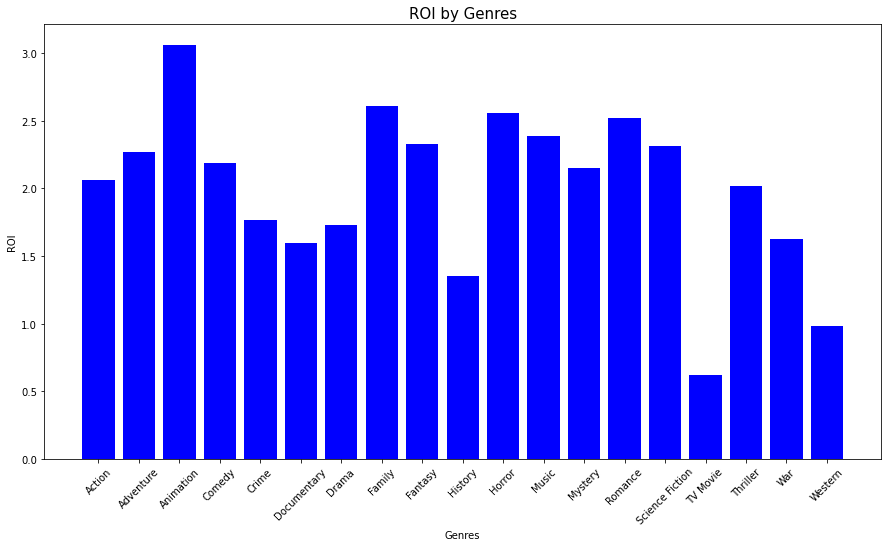

In [23]:
# Chart ROI by genres
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(x = roi_genres.index, height = roi_genres.values, color = 'blue')
plt.xticks(rotation = 45)
plt.xlabel('Genres')
plt.ylabel('ROI')
plt.title('ROI by Genres', fontsize = 15)
plt.show();

In [24]:
#combine the aggregate genres together and turn budget, revenue and ROI into separated columns
g = pd.concat([sum_budget_genres,sum_rev_genres, roi_genres], axis = 1)
g.columns = ['budget','revenue' ,'ROI']
#calculate to see what percentage of budget needed to achieve gross revenue
g['budget/rev'] = g['budget']/g['revenue']*100
# sort values with ROI and revenue as descending while budget as ascending
g.sort_values(by = ['ROI','budget/rev'], ascending = [False, True])[:10]

,budget,revenue,ROI,budget/rev
Animation,3173761905,12887223169,3,25
Family,4478295238,16153244216,3,28
Horror,2270333873,8090762134,3,28
Romance,2208368238,7783494817,3,28
Music,472733333,1602741319,2,29
Fantasy,5177499405,17252211819,2,30
Science Fiction,5929398750,19613437008,2,30
Adventure,10062379821,32951920652,2,31
Comedy,8805747744,28091860428,2,31
Mystery,1180781121,3724501544,2,32


My second recommendation is to focus on producing animation, horror, romance, and family movies, in the respected order. The reason I recommend these genres is due to their general low production cost relative to gross revenue and high ROI rate. As a result, the risk of loss due to high production cost in movie industry will be minimized if stakeholders' studio only invest in the four genres mentioned above, particularly animation.

### Third Recommendation

In [64]:
# Group the movies' stats by directors
directors_stats = df_dir.groupby(['primary_name']).aggregate({'production_budget':'mean', 
                                                              'worldwide_gross':'mean','ROI':'mean',
                                                              'averagerating':'mean','numvotes':'sum',
                                                             'title':'count'})
# Only include directors with at least 3 movies (average in this database) - 
# purpose is to exclude one-hit directors and look for consistent performers 
directors_stats = directors_stats[directors_stats.title >= 3]

# # Only include directors with at least 6 average rating (quality movies)
directors_stats = directors_stats[directors_stats.averagerating >= 6]

# # Rank directors by their ROI, average rating, and number of votes received for their movies, and 
# # only keep top 10
df_d = directors_stats.sort_values(by = ['ROI','averagerating'], ascending = [False,False])[:10]
df_d

,production_budget,worldwide_gross,ROI,averagerating,numvotes,title
primary_name,,,,,,
James DeMonaco,7333333,107105396,17,6,390006,3
David F. Sandberg,70000000,485038164,14,7,409154,4
Christopher Landon,8500000,73912366,12,6,192220,4
Scott Derrickson,66000000,284029664,11,7,776648,3
Damien Chazelle,27766667,190174675,11,8,1172995,3
Pierre Coffin,73333333,851136386,11,7,901321,3
Ryan Coogler,79300000,513125150,9,7,809006,3
James Wan,102500000,823719919,9,7,1190178,4
Leslie Small,4416667,21210245,8,7,21095,3


<ipython-input-65-91175dc8c5f4>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(df_d.index, rotation = 45)
<ipython-input-65-91175dc8c5f4>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(df_d.index, rotation = 45)


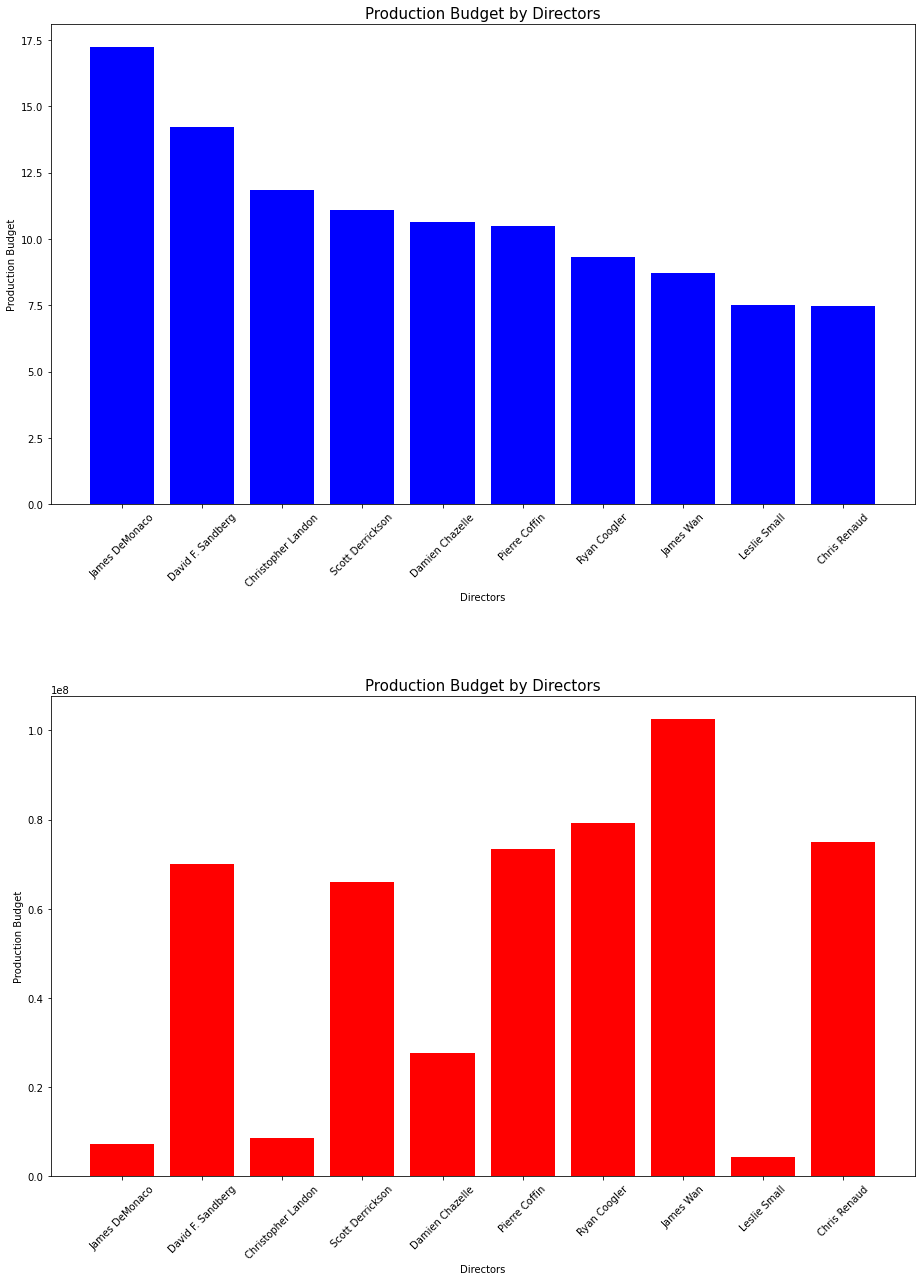

In [65]:
# Chart production budget
fig, ((ax1), (ax2)) = plt.subplots(figsize = (15,20), nrows = 2)

ax1.bar(x = df_d.index, height = df_d.ROI, color = 'blue')
ax1.set_xticklabels(df_d.index, rotation = 45)
ax1.set_ylabel('Production Budget')
ax1.set_xlabel('Directors')
ax1.set_title('Production Budget by Directors', fontsize = 15)

ax2.bar(x = df_d.index, height = df_d.production_budget, color = 'red')
ax2.set_xticklabels(df_d.index, rotation = 45)
ax2.set_ylabel('Production Budget')
ax2.set_xlabel('Directors')
ax2.set_title('Production Budget by Directors', fontsize = 15)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show();

My third recommendation to stakeholder is to select the 3 directors James DeMonaco, Christopher Landon, and Damien Chazelle for their studio investment. According to my analysis, these 3 directors not only achieve consistent good ROI rates with their movies but also awarded with high IMDb's average ratings. Moreover, to achieve such high ROI for their movies, these 3 directors don't need a large production budget. Thus, the investment cost required from the stakeholders' studio for new movies is also lower and the risk of loss will also be minimized.

### Summary

Based on our exploratory analysis, there are three recommendations I have for our stakeholders include:
* Prioritize releasing movie in October of the year. Not only we can avoid compete directly with major movies, but also have a higher chance of hitting higher ROI rates.
* Prioritize producing animation, horror, romance, and family movies due to their general low production cost relative to gross revenue and high ROI rate. 
* Prioritize inviting James DeMonaco, Christopher Landon, and Damien Chazelle  to be the directors of the company's movies. They not only have great experience in the movie industry but also good track record of turning small budget movies into great returns.